# Visualization of forward modelling statistics
## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pickle
import re
from pathlib import Path

## Loading the statistics parameters

In [2]:
OUTPUT_PATH = Path("../../../out_elec")
with open(OUTPUT_PATH / "args.txt", "r") as f:
    args = f.read()
print(f"args:\n{args}")

num_samples = re.search(r'Number of samples: (\d+)', args).group(1)
num_electrodes = re.search(r'Number of electrodes: (\d+)', args).group(1)
num_pixels_between_electrodes = list(map(int, re.search(r'Pixels between electrodes: \[(.*?)\]', args).group(1).split()))

args:
Data path: clean_reduced_unified
Number of samples: 1000
Number of electrodes: 48
Pixels between electrodes: [2 3]
Lateral padding: [4 6]
Scheme name: wa
Vertical fraction: 0.75



In [3]:
pseudosections = np.load(OUTPUT_PATH / "pseudosections.npy")
print(f"Loaded {pseudosections.shape[0]} series of pseudosections (each series has {pseudosections.shape[1]} pseudosections)")

timers = np.load(OUTPUT_PATH / "timers.npy")

with open(OUTPUT_PATH / "resistivity_models.pkl", "rb") as f:
    resistivity_models = pickle.load(f)

Loaded 1000 series of pseudosections (each series has 2 pseudosections)


## Time taken


Mean time per serie:
6 +/- 1.3 s/serie


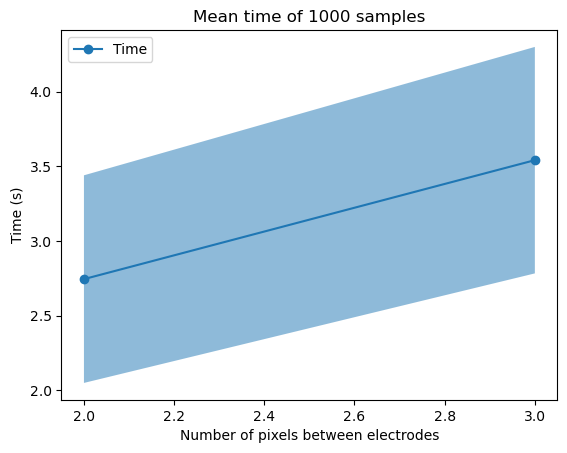

In [4]:
time_per_sample = timers.sum(axis=1)
print(f"\nMean time per serie:")
print(f"{time_per_sample.mean():.0f} +/- {time_per_sample.std():.1f} s/serie")

mean_timer_per_sapcing = timers.mean(axis=0)
std_timer_per_spacing = timers.std(axis=0)
plt.plot(num_pixels_between_electrodes, mean_timer_per_sapcing, label="Time", marker='o')
plt.fill_between(num_pixels_between_electrodes, mean_timer_per_sapcing - std_timer_per_spacing, mean_timer_per_sapcing + std_timer_per_spacing, alpha=0.5)
plt.legend()
plt.xlabel("Number of pixels between electrodes")
plt.ylabel("Time (s)")
plt.title(f"Mean time of {len(pseudosections)} samples")
plt.show()

## Visualize pseudosections

Check data quality

In [5]:
if (pseudosections < 0).any():
    print("Negative values found in pseudosections.")
    # Get the pseudo section with negative values
    idx = np.unique(np.where(pseudosections < 0)[0])
    print(f"Negative value at index {idx}")
    print(f"Replacing negative values with 1e-6")
    pseudosections[pseudosections < 0] = 1e-6

Choose an index in this range:

In [6]:
print(f"Choose an index between 1 and {len(pseudosections)} to plot the pseudosection")

Choose an index between 1 and 1000 to plot the pseudosection


In [7]:
# Set the index of the pseudosection to plot:
IDX = 50

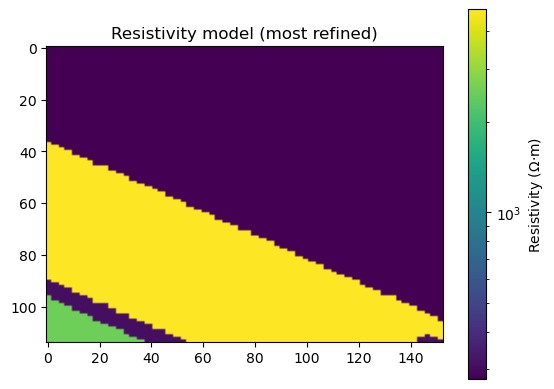

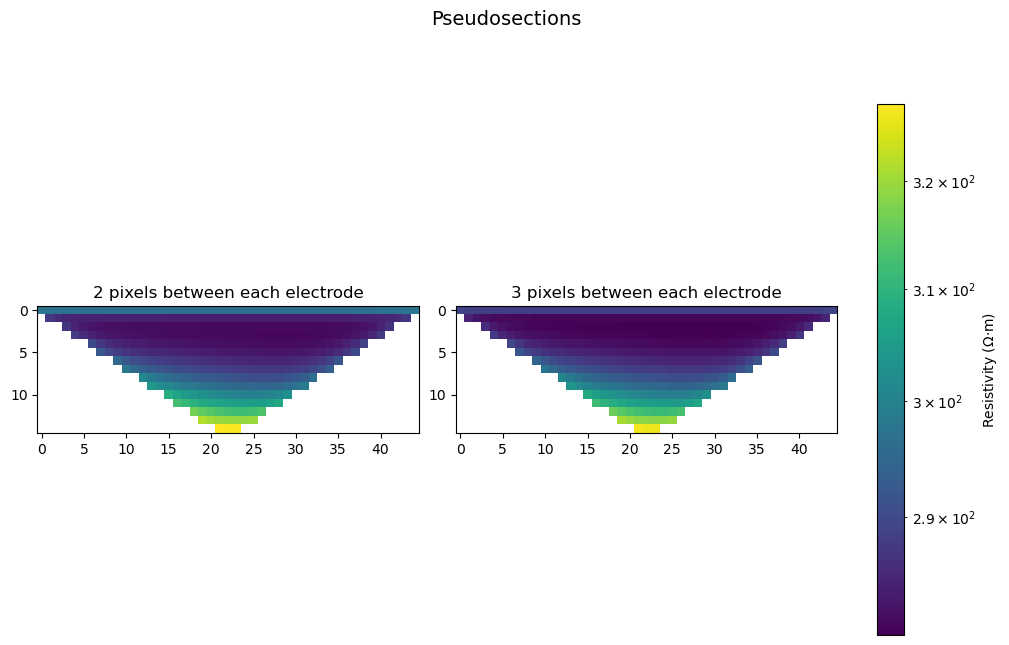

In [8]:
pseudo_section_idx = IDX - 1

vmin = max(np.nanmin(resistivity_models[pseudo_section_idx][-1]), 1e-6)
vmax = np.nanmax(resistivity_models[pseudo_section_idx][-1])
norm = mcolors.LogNorm(vmin=vmin, vmax=vmax)
# Plot the resistivity model
plt.imshow(resistivity_models[pseudo_section_idx][-1], cmap='viridis', norm=norm)
plt.colorbar(label=r'Resistivity ($\Omega$·m)')
plt.title("Resistivity model (most refined)")
plt.show()


num_rows = (len(pseudosections[pseudo_section_idx]) + 1) // 2
fig, axes = plt.subplots(num_rows, 2, figsize=(10, 7), constrained_layout=True)

vmin = max(np.nanmin(pseudosections[pseudo_section_idx]), 1e-6)
vmax = np.nanmax(pseudosections[pseudo_section_idx])
norm = mcolors.LogNorm(vmin=vmin, vmax=vmax)

# Plot each pseudosection
for idx, ax in enumerate(axes.flat):
    if idx >= len(pseudosections[pseudo_section_idx]):
        ax.axis('off')
        continue
    ax.imshow(pseudosections[pseudo_section_idx][idx], norm=norm, cmap='viridis')
    ax.set_title(f"{num_pixels_between_electrodes[idx]} pixel{'s' if num_pixels_between_electrodes[idx] > 1 else ''} between each electrode")
# Add colorbar to the right
cbar = fig.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap='viridis'),
    ax=axes.ravel().tolist(),
    location='right',
    shrink=0.8,
    label=r'Resistivity ($\Omega$·m)'
)

# Set figure title
fig.suptitle("Pseudosections", fontsize=14)
plt.show()

## Visualize difference between pseudosections when electrode spacing changes

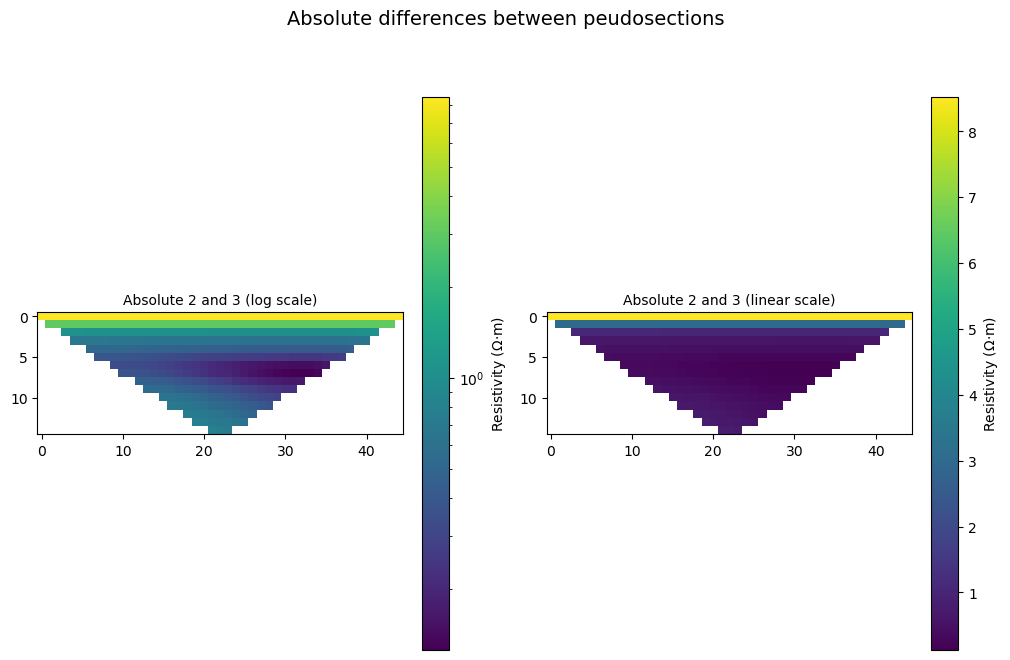

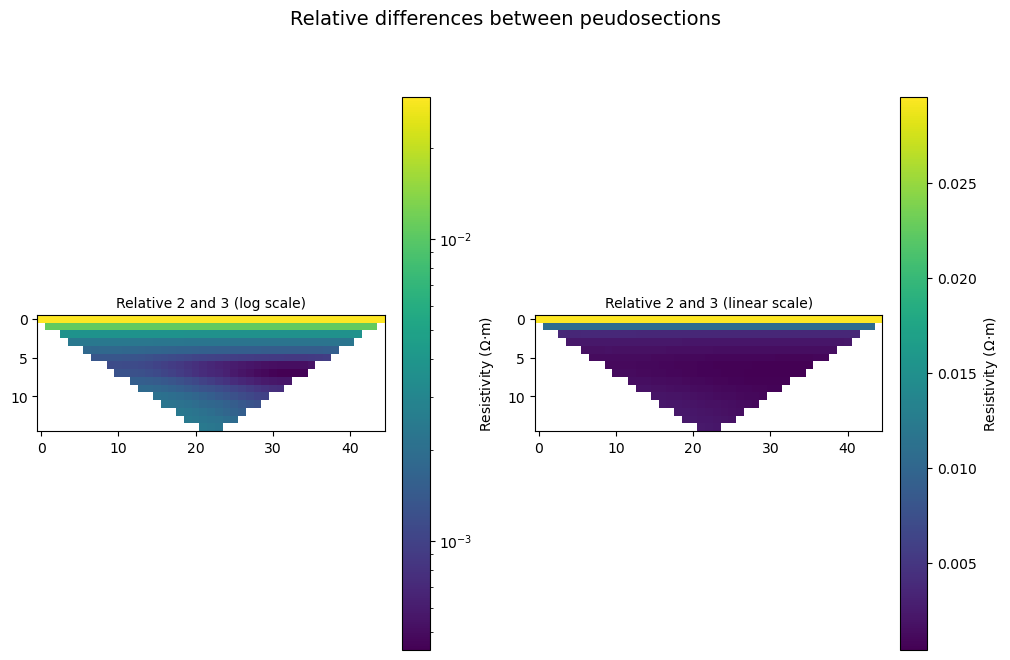

In [14]:
def compute_diff_pseudosections(pseudosections, pseudo_section_idx, relative=False):
    """
    Compute absolute or relative differences between consecutive pseudosections.
    """
    diffs = np.array(
        [
            np.abs(
                pseudosections[pseudo_section_idx][idx] - pseudosections[pseudo_section_idx][idx + 1] + 1e-6
            )
            for idx in range(len(pseudosections[pseudo_section_idx]) - 1)
        ]
    )
    if diffs.any() < 0:
        print("Negative values found in differences.")
    
    if relative:
        diffs = np.array(
            [diff / pseudosections[pseudo_section_idx][idx + 1] for idx, diff in enumerate(diffs)]
        )
        if diffs.any() < 0:
            print("Negative values found in relative differences.")
    
    return diffs, np.nanmin(diffs), np.nanmax(diffs)

def plot_pseudosections(diffs, min_diff, max_diff, title):
    """
    Plot the pseudosection differences using log and linear scales.
    """
    log_norm = mcolors.LogNorm(vmin=min_diff, vmax=max_diff)
    linear_norm = mcolors.Normalize(vmin=min_diff, vmax=max_diff)
    
    num_rows = len(diffs)
    fig, axes = plt.subplots(num_rows, 2, figsize=(10, 7), constrained_layout=True)
    
    for j, (scale, norm) in enumerate(zip(["log scale", "linear scale"], [log_norm, linear_norm])):
        if num_rows == 1:
            i = 0
            axes[j].imshow(diffs[i], norm=norm, cmap='viridis')
            axes[j].set_title(f"{title} {num_pixels_between_electrodes[i]} and {num_pixels_between_electrodes[i + 1]} ({scale})", fontsize=10)
        else:
            for i in range(num_rows):
                axes[i, j].imshow(diffs[i], norm=norm, cmap='viridis')
                axes[i, j].set_title(f"{title} {num_pixels_between_electrodes[i]} and {num_pixels_between_electrodes[i + 1]} ({scale})", fontsize=10)
        if num_rows == 1:
            fig.colorbar(
                plt.cm.ScalarMappable(norm=norm, cmap='viridis'),
                ax=axes[j],
                location='right',
                shrink=0.8,
                label=r'Resistivity ($\Omega$·m)'
            )
        else:
            fig.colorbar(
                plt.cm.ScalarMappable(norm=norm, cmap='viridis'),
                ax=axes[:, j].tolist(),
                location='right',
                shrink=0.8,
                label=r'Resistivity ($\Omega$·m)'
            )
    
    fig.suptitle(f"{title} differences between peudosections", fontsize=14, y=1.02)
    plt.show()

if len(pseudosections[0]) < 2:
    print("Not enough pseudosections to compute differences.")
else:
    # Compute and plot absolute differences
    diff_abs, min_abs, max_abs = compute_diff_pseudosections(pseudosections, pseudo_section_idx)
    plot_pseudosections(diff_abs, min_abs, max_abs, "Absolute")

    # Compute and plot relative differences
    diff_rel, min_rel, max_rel = compute_diff_pseudosections(pseudosections, pseudo_section_idx, relative=True)
    plot_pseudosections(diff_rel, min_rel, max_rel, "Relative")

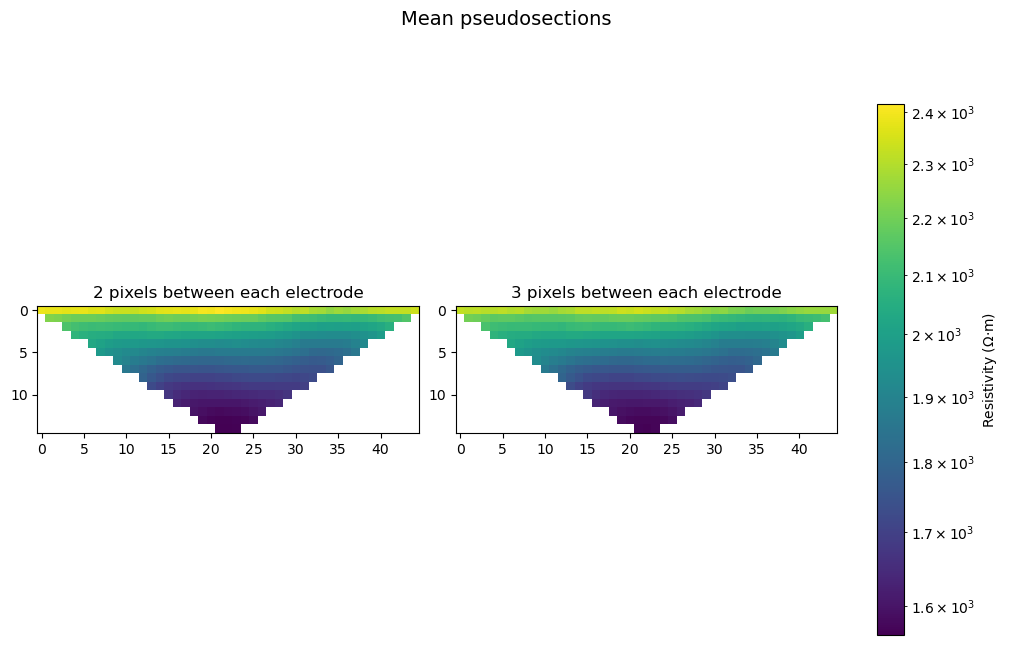

In [15]:
mean_pseudosections = np.mean(pseudosections, axis=0)

vmin = np.nanmin(mean_pseudosections)
vmax = np.nanmax(mean_pseudosections)

num_rows = (len(mean_pseudosections) + 1) // 2
fig, axes = plt.subplots(num_rows, 2, figsize=(10, 7), constrained_layout=True)
norm = mcolors.LogNorm(vmin=vmin, vmax=vmax)

# Plot each mean pseudosection
for idx, ax in enumerate(axes.flat):
    if idx >= len(pseudosections[pseudo_section_idx]):
        ax.axis('off')
        continue
    ax.imshow(mean_pseudosections[idx], norm=norm, cmap='viridis')
    ax.set_title(f"{num_pixels_between_electrodes[idx]} pixel{'s' if num_pixels_between_electrodes[idx] > 1 else ''} between each electrode")
# Add colorbar to the right
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='viridis'),
                    ax=axes.ravel().tolist(), location='right', shrink=0.8, label=r'Resistivity ($\Omega$·m)')

# Set figure title
fig.suptitle("Mean pseudosections", fontsize=14)
plt.show()

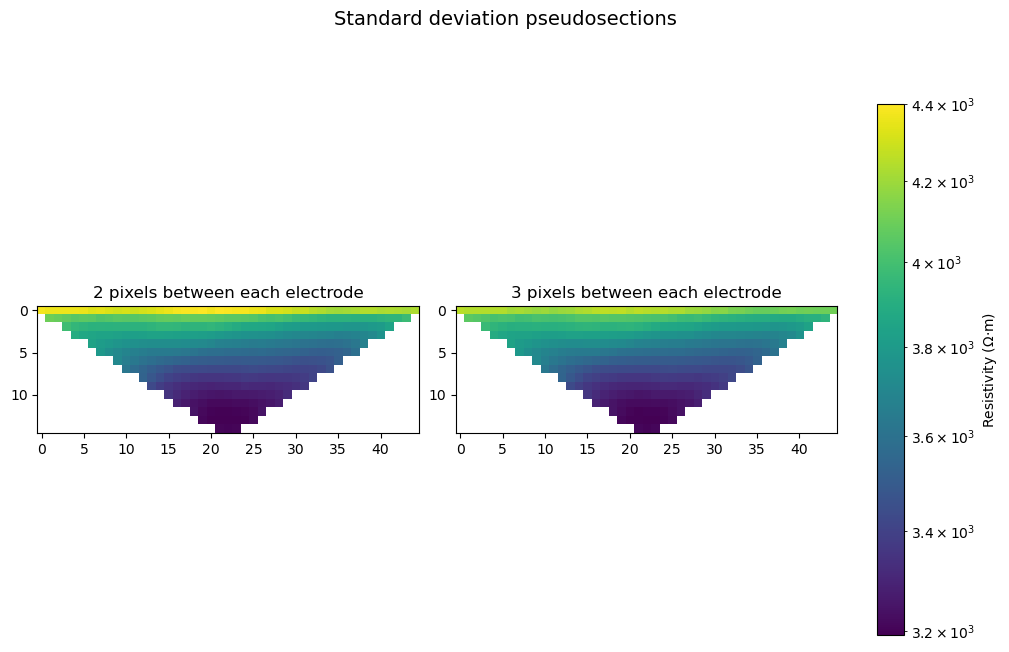

In [16]:
std_pseudosections = np.std(pseudosections, axis=0)

vmin = np.nanmin(std_pseudosections)
vmax = np.nanmax(std_pseudosections)

num_rows = (len(std_pseudosections) + 1) // 2
fig, axes = plt.subplots(num_rows, 2, figsize=(10, 7), constrained_layout=True)
norm = mcolors.LogNorm(vmin=vmin, vmax=vmax)

# Plot each mean pseudosection
for idx, ax in enumerate(axes.flat):
    if idx >= len(pseudosections[pseudo_section_idx]):
        ax.axis('off')
        continue
    ax.imshow(std_pseudosections[idx], norm=norm, cmap='viridis')
    ax.set_title(f"{num_pixels_between_electrodes[idx]} pixel{'s' if num_pixels_between_electrodes[idx] > 1 else ''} between each electrode")
# Add colorbar to the right
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='viridis'),
                    ax=axes.ravel().tolist(), location='right', shrink=0.8, label=r'Resistivity ($\Omega$·m)')

# Set figure title
fig.suptitle("Standard deviation pseudosections", fontsize=14)
plt.show()

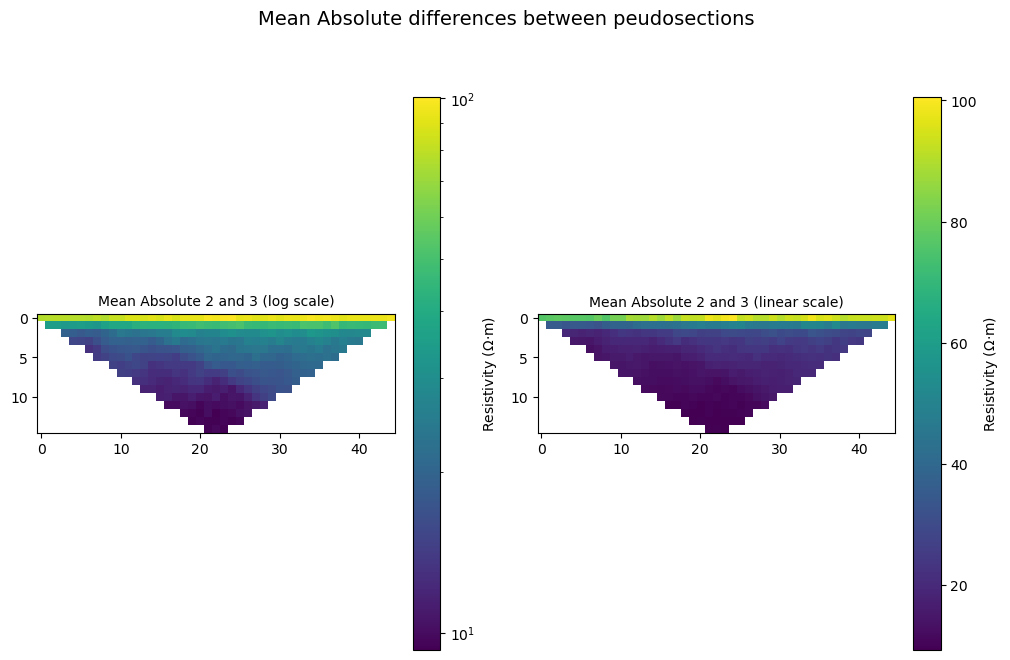

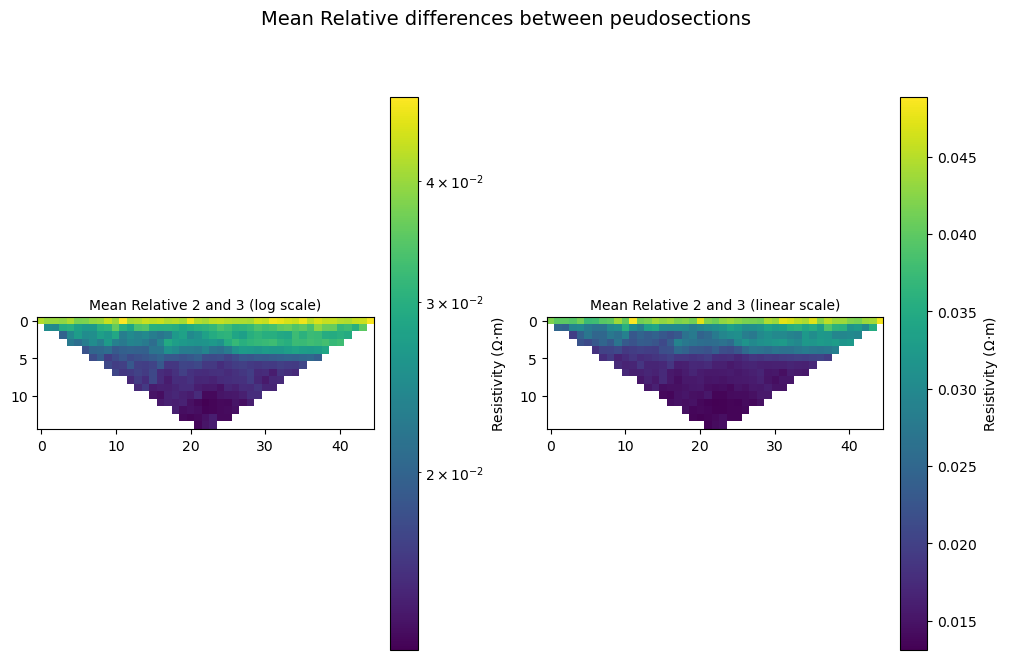

In [17]:
def plot_pseudosections(diffs, min_diff, max_diff, title):
    """
    Plot the pseudosection differences using log and linear scales.
    """
    log_norm = mcolors.LogNorm(vmin=min_diff, vmax=max_diff)
    linear_norm = mcolors.Normalize(vmin=min_diff, vmax=max_diff)
    
    num_rows = len(diffs)
    fig, axes = plt.subplots(num_rows, 2, figsize=(10, 7), constrained_layout=True)
    
    for j, (scale, norm) in enumerate(zip(["log scale", "linear scale"], [log_norm, linear_norm])):
        if num_rows == 1:
            i = 0
            axes[j].imshow(diffs[i], norm=norm, cmap='viridis')
            axes[j].set_title(f"{title} {num_pixels_between_electrodes[i]} and {num_pixels_between_electrodes[i + 1]} ({scale})", fontsize=10)
        else:
            for i in range(num_rows):
                axes[i, j].imshow(diffs[i], norm=norm, cmap='viridis')
                axes[i, j].set_title(f"{title} {num_pixels_between_electrodes[i]} and {num_pixels_between_electrodes[i + 1]} ({scale})", fontsize=10)
        
        if num_rows == 1:
            fig.colorbar(
                plt.cm.ScalarMappable(norm=norm, cmap='viridis'),
                ax=axes[j],
                location='right',
                shrink=0.8,
                label=r'Resistivity ($\Omega$·m)'
            )
        else:
            fig.colorbar(
                plt.cm.ScalarMappable(norm=norm, cmap='viridis'),
                ax=axes[:, j].tolist(),
                location='right',
                shrink=0.8,
                label=r'Resistivity ($\Omega$·m)'
            )
    
    fig.suptitle(f"{title} differences between peudosections", fontsize=14, y=1.02)
    plt.show()
"""
if len(pseudosections[0]) < 2:
    print("Not enough pseudosections to compute differences.")
else:
    # Compute and plot absolute differences
    diff_abs, min_abs, max_abs = compute_diff_pseudosections(pseudosections, pseudo_section_idx)
    plot_pseudosections(diff_abs, min_abs, max_abs, "Absolute")

    # Compute and plot relative differences
    diff_rel, min_rel, max_rel = compute_diff_pseudosections(pseudosections, pseudo_section_idx, relative=True)
    plot_pseudosections(diff_rel, min_rel, max_rel, "Relative")
"""



if len(pseudosections[0]) < 2:
    print("Not enough pseudosections to compute differences.")
else:
    diff_abs_arr = np.zeros((pseudosections.shape[0], pseudosections.shape[1] - 1, *pseudosections.shape[2:]))
    diff_rel_arr = np.zeros((pseudosections.shape[0], pseudosections.shape[1] - 1, *pseudosections.shape[2:]))
    for serie_idx, serie in enumerate(pseudosections):
        diff_abs, *_ = compute_diff_pseudosections(pseudosections, serie_idx)
        diff_rel, *_ = compute_diff_pseudosections(pseudosections, serie_idx, relative=True)
        diff_abs_arr[serie_idx] = diff_abs
        diff_rel_arr[serie_idx] = diff_rel


    # Compute the mean of the differences
    mean_diff_abs = np.mean(diff_abs_arr, axis=0)
    mean_diff_rel = np.mean(diff_rel_arr, axis=0)

    min_abs = np.nanmin(mean_diff_abs)
    max_abs = np.nanmax(mean_diff_abs)
    min_rel = np.nanmin(mean_diff_rel)
    max_rel = np.nanmax(mean_diff_rel)

    plot_pseudosections(mean_diff_abs, min_abs, max_abs, "Mean Absolute")
    plot_pseudosections(mean_diff_rel, min_rel, max_rel, "Mean Relative")

In [18]:
rock_class_count: int = 0
rock_class_count_squared: int = 0
max_class_count = 0
min_class_count = np.inf
for resistivity_model in resistivity_models:
    len_rock_class = len(np.unique(resistivity_model[0]))
    rock_class_count += len_rock_class
    rock_class_count_squared += len_rock_class ** 2
    max_class_count = max(max_class_count, len_rock_class)
    min_class_count = min(min_class_count, len_rock_class)
mean_rock_class_count = rock_class_count / len(resistivity_models)
std_rock_class_count = np.sqrt(rock_class_count_squared / len(resistivity_models) - mean_rock_class_count ** 2)
print(f"Average number of rock classes: {mean_rock_class_count:.2f} +/- {std_rock_class_count:.2f}")
print(f"Max number of rock classes: {max_class_count}")
print(f"Min number of rock classes: {min_class_count}")

Average number of rock classes: 4.28 +/- 1.87
Max number of rock classes: 12
Min number of rock classes: 1


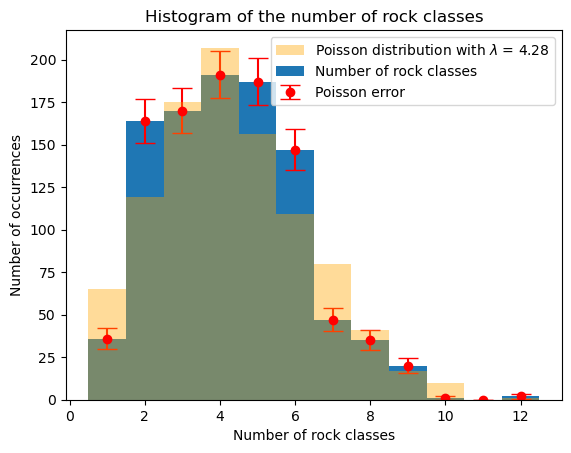

In [22]:
num_rock_classes: np.ndarray[int] = np.array([len(np.unique(resistivity_model[-1])) for resistivity_model in resistivity_models], dtype=int)

bins: np.ndarray[int] = np.arange(1, num_rock_classes.max() + 2) - 0.5

hist_counts, bin_edges = np.histogram(num_rock_classes, bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

errors = np.sqrt(hist_counts)

# Plot histogram
plt.bar(bin_centers, hist_counts, width=1, label="Number of rock classes", zorder=1)

# Add error bars
plt.errorbar(bin_centers, hist_counts, yerr=errors, fmt='o', color='red', capsize=7, label="Poisson error")


y = np.random.poisson(mean_rock_class_count, len(num_rock_classes))

#plt.hist(num_rock_classes, bins=bins, edgecolor='black', label="Number of rock classes", )
plt.hist(y, bins=bins, label=fr"Poisson distribution with $\lambda$ = {mean_rock_class_count:.2f}", color='orange', zorder=2, alpha=0.4)
plt.legend()
plt.xlabel("Number of rock classes")
plt.ylabel("Number of occurrences")
plt.title("Histogram of the number of rock classes")
plt.show()